<a href="https://colab.research.google.com/github/SreeramNithin/UNP-Projects/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = np.load('/content/drive/MyDrive/CIfar/cifar-10.zip')

In [ ]:
data.files

['sampleSubmission.csv', 'test.7z', 'train.7z', 'trainLabels.csv']

In [ ]:
train_images = data['train.7z']
test_images = data['test.7z']

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 28
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
keras=tf.keras
from keras.datasets import cifar10

In [ ]:
(trainX, trainY),(testX , testY) = cifar10.load_data()

170498071/170498071 [==============================] - 4s 0us/step


In [ ]:
print('Train: X=',trainX.shape)
print('Test: X=',testX.shape)

Train: X= (50000, 32, 32, 3)
Test: X= (10000, 32, 32, 3)


<function matplotlib.pyplot.show(*args, **kw)>

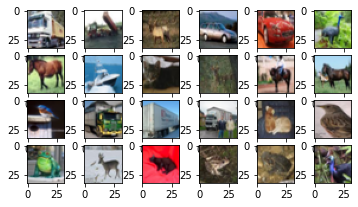

In [ ]:
for i in range(1,25):
  plt.subplot(5,6,i)
  plt.imshow(trainX[i], cmap=plt.get_cmap('gray'))
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

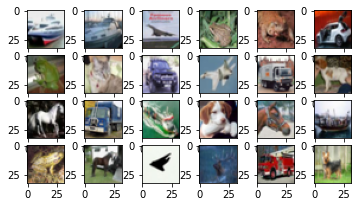

In [ ]:
for i in range(1,25):
  plt.subplot(5,6,i)
  plt.imshow(testX[i], cmap=plt.get_cmap('gray'))
plt.show

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [ ]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
# test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-27-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.261890
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.310957
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.282214
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.266747
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.256522
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.213005
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.235751
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.192814
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.119913
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.118474
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.943586
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.692223
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.806040
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.447262
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.568866
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.306140
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.323073
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.404993
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.076847
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.171385
Train Epoch: 1 [12800/60000 (

/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.1743, Accuracy: 9473/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.577310
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.454149
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.468016
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.204435
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.262322
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.270256
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.373612
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.651483
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.395327
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.367662
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.412050
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.388974
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.522943
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.584254
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.488037
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.370178
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.383885
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.362436
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.265527
Train Epoch: 2 [12160

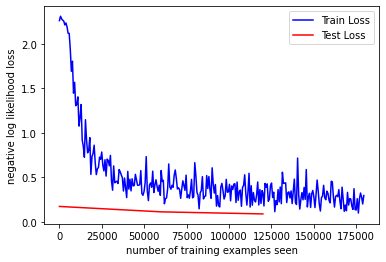

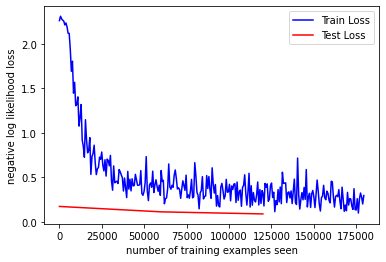

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.plot(test_counter[:-1], test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig